# PPM Advection

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from grid import FVGrid
from reconstruction import PPMInterpolant

In [15]:
def states(grid, a, u, dt):
    a_ppm = PPMInterpolant(grid, a)
    sigma = u * dt / grid.dx
    
    # Im is the left side of the zone, Ip is the right side of the zone
    Im, Ip = a_ppm.integrate(sigma)

    # convert these to be left and right of an interface
    aleft = grid.scratch_array()
    aright = grid.scratch_array()

    aright[:] = Im[:]
    aleft[1:] = Ip[:-1]

    return aleft, aright

In [24]:
def advection(nx, u, C, *, num_periods=1, init_cond=None):

    g = FVGrid(nx, ng=3)

    t_period = (g.xmax - g.xmin) / np.abs(u)
    tmax = num_periods * t_period

    # setup the initial conditions
    a_init = g.scratch_array()
    init_cond(g, a_init)
    
    # compute the timestep
    dt = C * g.dx / np.abs(u)

    a = g.scratch_array()
    a[:] = a_init[:]
    
    t = 0.0
    while t < tmax:
        if t + dt > tmax:
            dt = tmax - t

        g.fill_BCs(a)

        # get the interface states
        a_left, a_right = states(g, a, u, dt)
        print(a_left)
        # solve the Riemann problem
        a_int = np.where(u > 0, a_left, a_right)
        
        # do the update
        a[g.lo:g.hi+1] += -dt * u * (a_int[g.lo+1:g.hi+2] - a_int[g.lo:g.hi+1]) / g.dx
        t += dt

    return g, a

In [25]:
def tophat(g, a):
    a[:] = 0.0
    a[np.logical_and(g.x >= 1./3., g.x <= 2./3.)] = 1.0

In [26]:
g, a = advection(64, 1.0, 0.5, num_periods=0.5, init_cond=tophat)

[0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
[0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
[0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.2

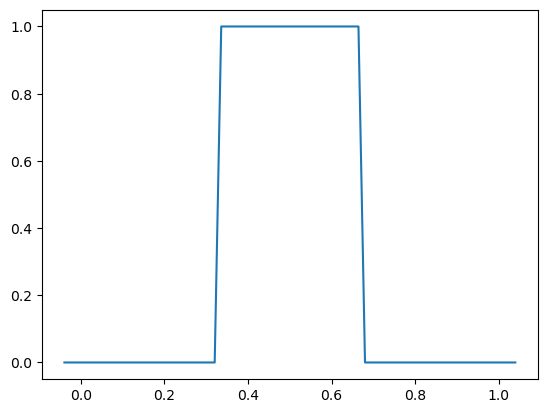

In [23]:
fig, ax = plt.subplots()
ax.plot(g.x, a)